In [1]:
import pandas as pd
from itertools import product

# site-packages path
from distutils.sysconfig import get_python_lib
print(get_python_lib())

c:\Users\user\anaconda3\envs\yolo3\Lib\site-packages


# GENERATING CONFIGS

In [32]:
header_colors = ['yellow', 'orange', 'red', 'nocolor']
shnek_materials = ['yellow', 'orange', 'red', 'nocolor']

wear_types = ['linear', 'quadratic', 'exp', 'root']
header_types = [f'header_{i}' for i in range(10)]

background_types = ['coal', 'salt']
rotation_angles = [i for i in range(0,360,15)]

wear_ratios = [i / 10 for i in range(0,21,2)]
unwear_heights = [i / 100 for i in range(10, 100, 18)]

combos = list(product(*[header_colors, shnek_materials, wear_types, header_types, background_types, rotation_angles, wear_ratios, unwear_heights]))
print(len(combos))

df = pd.DataFrame(combos, columns=['header_color', 'shnek_material', 'wear_type', 'header_type', 'background_type', 'rotation_angle', 'wear_ratio', 'unwear_height'])
df.to_csv('configs.csv', index=False)

1689600

# LABELING IMAGE

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


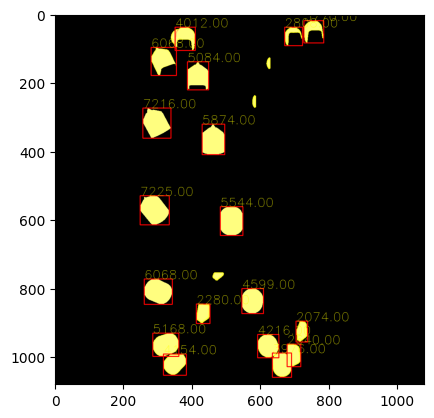

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import colors

import os
from glob import glob
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = '1'

import cv2 as cv
import numpy as np
import pandas as pd
%matplotlib inline

image_num = '342056'
BINARY_IMAGE_PATH = 'data\\images\\mask\\'
COLOR_MASK_IMAGE_PATH = 'data\\images\\mask colored\\'
# flags = [i for i in dir(cv) if i.startswith('COLOR_') and 'hsv' in i.lower()]
# print( flags )

def trim_binary_image(img):
    if img.max() == 0:
        print('Zero-image')
        return (0,0,0,0)
    """Accepts only binarized images else result unpredictable"""
    horizCropArr = np.argmax(img, axis=1)
    lcrop = horizCropArr[horizCropArr != 0].min()

    vertCropArr = np.argmax(img, axis=0)
    ucrop = vertCropArr[vertCropArr != 0].min() if img[0,:].max() == 0 else 0

    # Rotating image by 180 degrees
    img_rot = np.rot90(img, 2)

    horizCropArr_rot = np.argmax(img_rot, axis=1)
    # rcrop = horizCropArr_rot[horizCropArr_rot != 0].min() if img[:,0].max() == 0 else 0
    rcrop = horizCropArr_rot[horizCropArr_rot != 0].min()
    rcrop = img.shape[1] - rcrop

    vertCropArr_rot = np.argmax(img_rot, axis=0)
    if img_rot[0,:].max() == 0:
        dcrop = vertCropArr_rot[vertCropArr_rot != 0].min()
    else:
        dcrop = 0
    dcrop = img.shape[0] - dcrop

    return (lcrop, ucrop, rcrop, dcrop)
    # return img[ucrop:dcrop, lcrop:rcrop]

def apply_mask(orig, mask):
    img = orig.copy()
    for i in range(3):
        img[:,:,i:i+1] = np.minimum(img[:,:,i:i+1], np.expand_dims(mask, axis=2))
    return img


def read_binary_image(image_num):
    bin_mask = Image.open(os.path.join(BINARY_IMAGE_PATH, f'{image_num}.png'), mode='r').convert('L')
    bin_mask = bin_mask.point(lambda p: 255 if p > 128 else 0)
    bin_mask_np = np.array(bin_mask, dtype=np.uint8)
    return bin_mask_np



def read_color_mask_image(image_num):
    img = cv.imread(os.path.join(COLOR_MASK_IMAGE_PATH, f'{image_num}.exr'), cv.IMREAD_ANYCOLOR | cv.IMREAD_ANYDEPTH) * 5
    bin_mask_np = read_binary_image(image_num)
    img = apply_mask(img,bin_mask_np)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    return img

def labeling(image_num):
    img = read_color_mask_image(image_num)
    width, height = img.shape[0], img.shape[1]

    h = img[:,:,0] # H channel of HSV image

    freqs = pd.Series(h[h>0]).apply(lambda x: round(x,2)).value_counts()
    freqs = freqs[freqs > 50]

    h_rounded = np.around(h.copy(), 2)

    to_draw = img.copy()
    labels = []
    for hh in freqs.index:
        h_rounded_ge = h_rounded >= hh - 0.1
        h_rounded_le = h_rounded <= hh + 0.1
        res_masked = np.logical_and(h_rounded_ge, h_rounded_le).astype(np.uint8)

        rectangle = trim_binary_image(res_masked)

        l,u,r,d = rectangle
        x, y = l + (r-l) / 2, u + (d-u) / 2
        w, h = (r-l), (d-u)
        S = w * h

        # skip tiny objects
        if S < 1200:
            continue

        # saving labels
        x_rel, y_rel, w_rel, h_rel = x / width, y / height, w / width, h / height
        label = f'{x_rel} {y_rel} {w_rel} {h_rel}'
        labels.append(label)

        # put rectangle and label to this rectangle
        cv.rectangle(to_draw, (l,u), (r,d), color=(255,0,0), thickness=2)
        cv.putText(to_draw, f"{S:.2f}", (l,u), fontFace=cv.FONT_HERSHEY_SIMPLEX, fontScale=1.2, color=(1,1,0))

    with open(f'data\\labels\\{image_num}.txt', 'w') as f:
        f.write('\n'.join(labels))

    plt.imshow(to_draw)      
    
def create_labels(images_path='data\\images\\original'):
    img_names = glob(images_path + '\\*')
    img_names = [name.split('\\')[-1].split('.')[0] for name in img_names]
    for img_name in img_names:
        labeling(img_name)
    
def main():
    create_labels()
    
if __name__ == '__main__':
    main()

In [26]:
from glob import glob

imgs = [img.split('\\')[-1] for img in glob('data\\images\\original\\*')]
labels = [label.split('\\')[-1] for label in glob('data\\labels\\*')]

In [29]:
pd.DataFrame({'img':imgs, 'label':labels}).to_csv('example.csv', index=False)

In [45]:
# DATASET
import torch
import torch.nn as nn
import os
import pandas as pd
from PIL import Image

class RezcyDataset(torch.utils.data.Dataset):
    def __init__(
        self, csv_file, img_dir, label_dir, S=7, B=4, transform=None
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.S = S
        self.B = B
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        
        with open(label_path, 'r') as f:
            for label in f.readlines():
                x, y, w, h = [
                    float(i) if float(i) != int(float(i)) else int(i)
                    for i in label.strip().split(' ')
                ]
                boxes.append([x, y, w, h])
                
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)
        
        if self.transform:
            image, boxes = self.transform(image, boxes)
            
        label_matrix = torch.zeros((self.S, self.S, 5 * self.B))
        for box in boxes:
            x, y, w, h = box
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i
            width, height = self.S * w, self.S * h
            
            if label_matrix[i,j,0] == 0:
                label_matrix[i,j,0] = 1
                label_matrix[i,j,1:5] = torch.tensor([x_cell, y_cell, width, height])
                
        return image, label_matrix
    
ds = RezcyDataset(
    'example.csv',
    'data\\images\\original',
    'data\\labels',
    transform=transform
)

In [1]:
# import torch
# import torchvision.transforms as transforms
# import torchvision.transforms.functional as FT
# import torch.optim as optim
# from torch.utils.data import DataLoader

# torch.autograd.set_detect_anomaly(True)

# from model import Yolov11
# from dataset import RezcyDataset
# from loss import Yolov11Loss
# from utils import (
#     intersection_over_union,
#     non_max_suppression,
#     mean_average_precision,
#     cellboxes_to_boxes,
#     get_bboxes,
#     plot_image,
#     save_checkpoint,
#     load_checkpoint
# )

# from tqdm import tqdm

# seed = 123
# torch.manual_seed(seed)

# # Hyperparameters
# LEARNING_RATE = 2e-5
# DEVICE = "cpu"
# BATCH_SIZE = 4
# WEIGHT_DECAY = 0
# EPOCHS = 2
# NUM_WORKERS = 1
# PIN_MEMORY = False
# LOAD_MODEL = False
# LOAD_MODEL_FILE = "model.pt"
# IMG_DIR = "data\\images\\original"
# LABEL_DIR = "data\\labels"

# class Compose(object):
#     def __init__(self, transforms):
#         self.transforms = transforms
        
#     def __call__(self, img, bboxes):
#         for t in self.transforms:
#             img, bboxes = t(img), bboxes
            
#         return img, bboxes
            
# transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

# def train_fn(train_loader, model, optimizer, loss_fn):
#     loop = tqdm(train_loader, leave=True)
#     mean_loss = []
    
#     for batch_idx, (x,y) in enumerate(loop):
#         x, y = x.to(DEVICE), y.to(DEVICE)
#         out = model(x)
#         loss = loss_fn(out, y)
#         mean_loss.append(loss.item())
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         # Update the progress bar
#         loop.set_postfix(loss = loss.item())
        
#         # Saving model's state and checkpoints
#         # save_checkpoint(model.state_dict(), 'checkpoints\\model\\my_checkpoint.pth.tar')
#         # save_checkpoint(optimizer.state_dict(), 'checkpoints\\optimizer\\my_checkpoint.pth.tar')
#         torch.save({
#             'batch_idx': batch_idx,
#             'state_dict': model.state_dict(),
#             'optimizer': optimizer.state_dict(),
#             'loss': loss,
            
#         }, f'checkpoints\\{LOAD_MODEL_FILE}')
        
#     print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")
          
# def main():
#     model = Yolov11(
#         split_size = 7,
#         num_boxes = 2
#     ).to(DEVICE)
          
#     optimizer = optim.Adam(
#         model.parameters(),
#         lr = LEARNING_RATE,
#         weight_decay = WEIGHT_DECAY
#     )
          
#     loss_fn = Yolov11Loss()
    
#     if LOAD_MODEL:
#         load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)
        
#     train_dataset = RezcyDataset(
#         'example.csv',
#         transform=transform,
#         img_dir=IMG_DIR,
#         label_dir=LABEL_DIR
#     )
        
#     test_dataset = RezcyDataset(
#         'example.csv',
#         transform=transform,
#         img_dir=IMG_DIR,
#         label_dir=LABEL_DIR
#     )
    
#     train_loader = DataLoader(
#         dataset = train_dataset,
#         batch_size=BATCH_SIZE,
#         num_workers=NUM_WORKERS,
#         pin_memory=PIN_MEMORY,
#         shuffle=True,
#         drop_last=False
#     )
    
#     test_loader = DataLoader(
#         dataset = test_dataset,
#         batch_size=BATCH_SIZE,
#         num_workers=NUM_WORKERS,
#         pin_memory=PIN_MEMORY,
#         shuffle=True,
#         drop_last=True
#     )
    
#     for epoch in range(EPOCHS):
#         pred_boxes, target_boxes = get_bboxes(
#             train_loader,
#             model,
#             iou_threshold=0.5,
#             threshold=0.4
#         )
        
#         mean_avg_prec = mean_average_precision(
#             pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
#         )
        
#         print(f"Train mAP: {mean_avg_prec}")
        
#         train_fn(train_loader, model, optimizer, loss_fn)
        
# # if __name__ == '__main__':
# #     main()
# # main()

c:\Users\e.tarasov\Anaconda3\envs\yolov5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = Yolov11(
        split_size = 7,
        num_boxes = 2
    ).to(DEVICE)

In [3]:
# model = models.resnet18()
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 469.296MB


In [6]:
import requests

resp = requests.get('https://5h4slp9e6vy-496ff2e9c6d22116-8000-colab.googleusercontent.com/')

In [11]:
# headers = {
#     'Upgrade-Insecure-Requests': '1',
#     'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36',
#     'sec-ch-ua': '"Google Chrome";v="111", "Not(A:Brand";v="8", "Chromium";v="111"',
#     'sec-ch-ua-mobile': '?0',
#     'sec-ch-ua-platform': '"Windows"',
# }

# response = requests.get('https://6191-35-238-216-206.ngrok.io:4040')
# response.status_code, response.reason

ConnectTimeout: HTTPSConnectionPool(host='6191-35-238-216-206.ngrok.io', port=4040): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000204C38193F0>, 'Connection to 6191-35-238-216-206.ngrok.io timed out. (connect timeout=None)'))

In [12]:
def upload_images_to_google_drive(
    image_num, 
    mask_colored_folder_name='mask colored',
    mask_folder_name='mask',
    original_folder_name='original',
):
    folderName = 'yolo'  # Please set the folder name.

    folders = drive.ListFile(
        {'q': "title='" + folderName + "' and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()
    for folder in folders:
        if folder['title'] == folderName:
            subfolders = drive.ListFile({'q': f"'{folder['id']}' in parents and trashed=false"}).GetList()
            for subf in subfolders:
                if subf['title'] == mask_colored_folder_name:
                    mask_colored_folder = subf
                    continue
                if subf['title'] == mask_folder_name:
                    mask_folder = subf
                    continue
                if subf['title'] == original_folder_name:
                    original_folder = subf
                    continue
    
    file_png = drive.CreateFile({
        'parents': [{
            'id': original_folder['id'], 
            'kind': 'drive#fileLink'
        }], 'mimeType': 'image/x-png', 
        'title': f'{image_num}.png'
    })
    file_png.SetContentFile(f'data\\images\\{original_folder_name}\\{image_num}.png')
    file_png.Upload()
    
    file_png = drive.CreateFile({
        'parents': [{
            'id': mask_folder['id'], 
            'kind': 'drive#fileLink'
        }], 'mimeType': 'image/x-png', 
        'title': f'{image_num}.png'
    })
    file_png.SetContentFile(f'data\\images\\{mask_folder_name}\\{image_num}.png')
    file_png.Upload()
    
    file_exr = drive.CreateFile({
        'parents': [{
            'id': mask_colored_folder['id'], 
            'kind': 'drive#fileLink'
        }], 'mimeType': 'image/x-exr', 
        'title': f'{image_num}.exr'
    })
    file_exr.SetContentFile(f'data\\images\\{mask_colored_folder_name}\\{image_num}.exr')
    file_exr.Upload()
    
if __name__ == '__main__':
    # upload_images_to_google_drive('361244')
    print('main')